<a href="https://colab.research.google.com/github/acse-srm3018/Driverless_Car/blob/main/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 11.47 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail


data['center'] = data['center'].apply(path_leaf)  
data['left'] = data['left'].apply(path_leaf) 
data['right'] = data['right'].apply(path_leaf) 
data.head()


center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

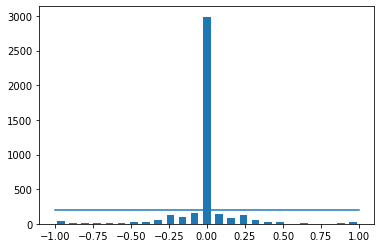

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+ bins[1:])*0.5
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaing:', len(data))

total data: 4053
removed: 2790
remaing: 1263


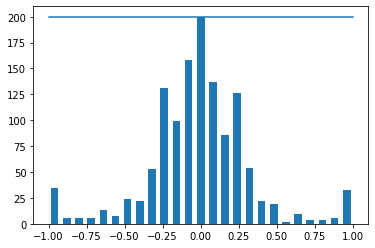

In [ ]:
hist,_ = np.histogram(data['steering'], (num_bins))
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings



image_paths, steerings = load_img_steering(datadir + '/IMG', data)


center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

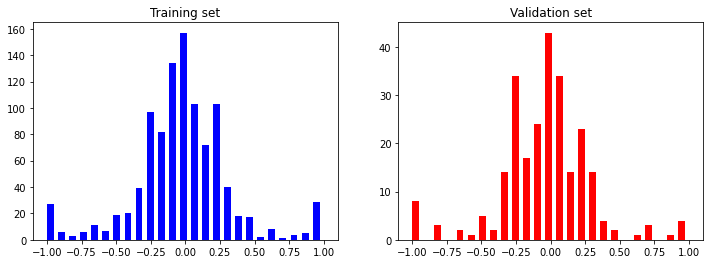

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale =(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

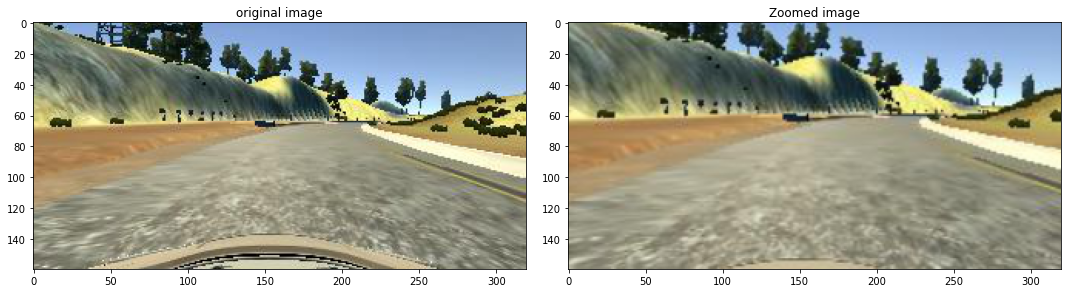

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x":(-0.1,0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

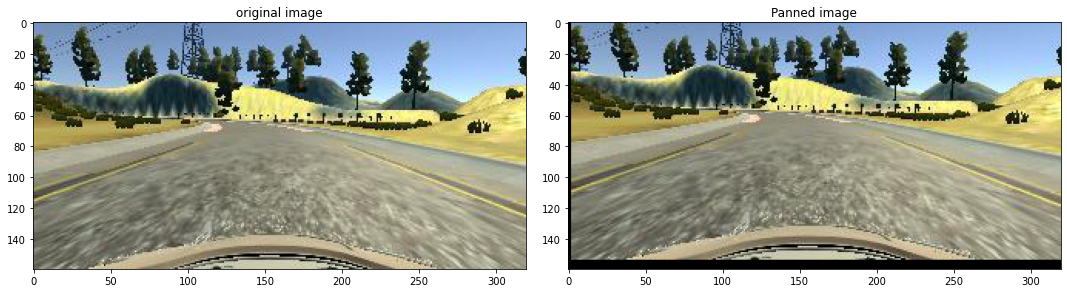

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

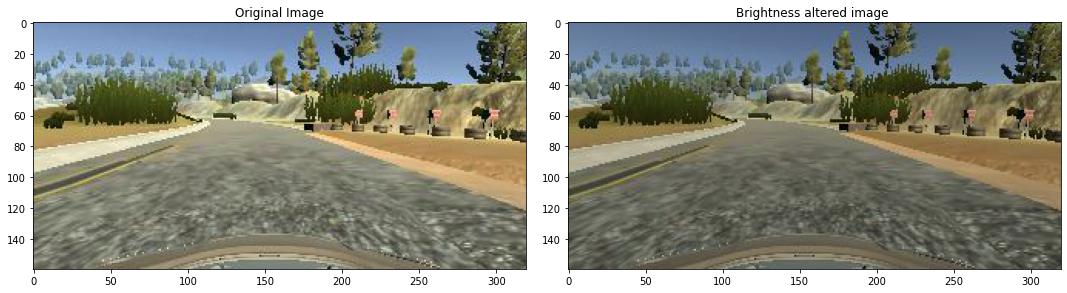

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped_Image_steering Angle :-0.0')

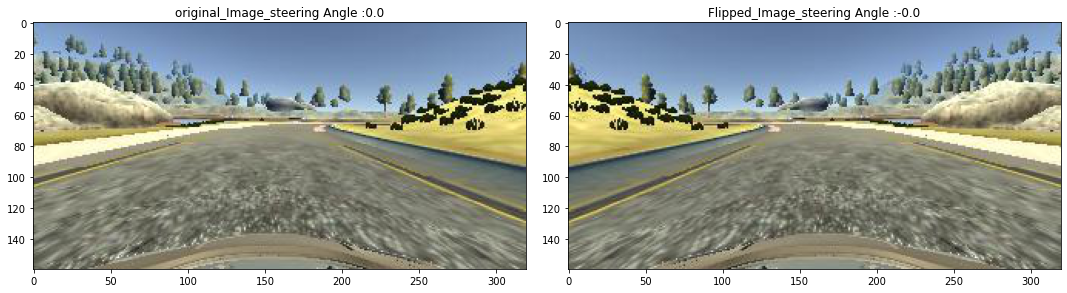

In [ ]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original_Image_' +'steering Angle :' +str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped_Image_' +'steering Angle :' +str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()< 0.5:
    image = pan(image)
  if np.random.rand()< 0.5:
    image = zoom(image)
  if np.random.rand()< 0.5:
    image = img_random_brightness(image)
  if np.random.rand()< 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

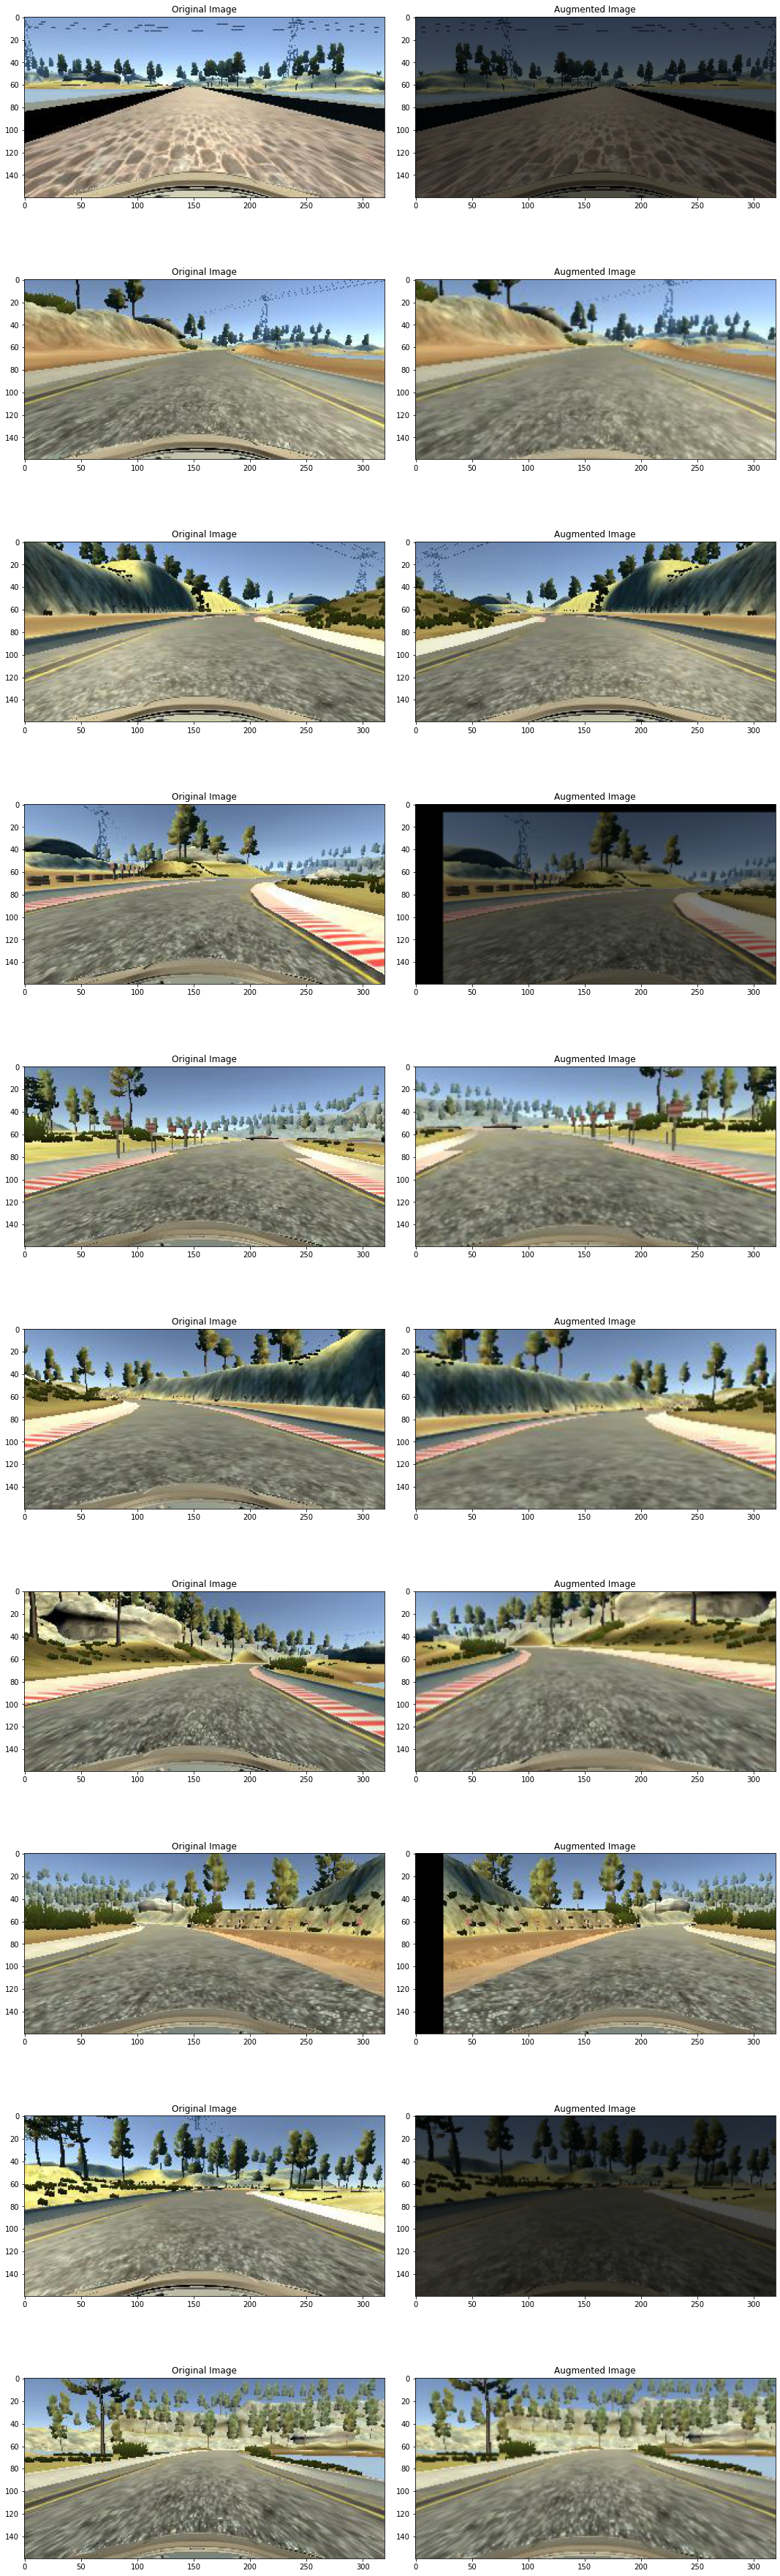

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")


In [ ]:
def img_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

(66, 200, 3)


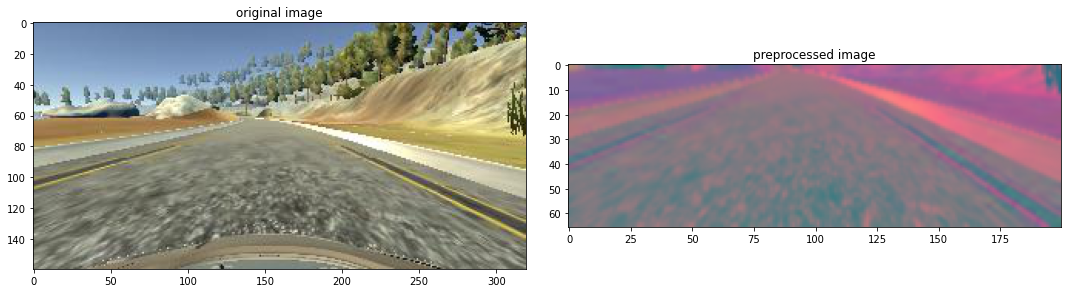

In [ ]:
image =image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image') 
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed image') 
print(preprocessed_image.shape)

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

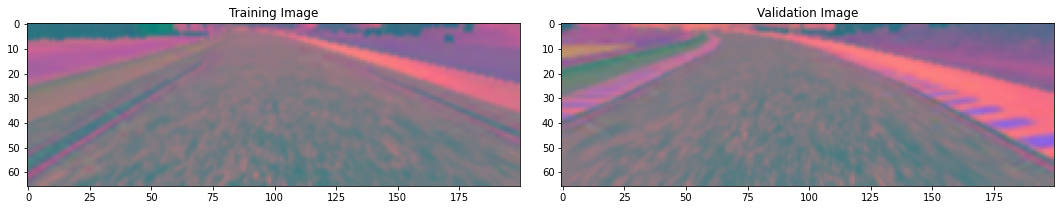

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')
                   

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5,5), subsample = (2,2), input_shape = (66,200,3), activation = 'elu'))
  model.add(Conv2D(36, (5,5), subsample = (2,2), activation = 'elu'))
  model.add(Conv2D(48, (5,5), subsample = (2,2), activation = 'elu'))
  model.add(Conv2D(64, (3,3),  activation = 'elu'))
  model.add(Conv2D(64, (3,3),  activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(Adam(lr=1e-4), loss='mse')
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """


In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch= 300,
                              epochs =10, 
                              validation_data=batch_generator(X_valid,y_valid, 100, 0), 
                              validation_steps =200,
                              verbose=1, 
                              shuffle=1)

Epoch 1/10
300/300 [==============================] - 401s 1s/step - loss: 0.0881 - val_loss: 0.0595
Epoch 2/10
300/300 [==============================] - 389s 1s/step - loss: 0.0679 - val_loss: 0.0380
Epoch 3/10
300/300 [==============================] - 387s 1s/step - loss: 0.0609 - val_loss: 0.0445
Epoch 4/10
300/300 [==============================] - 389s 1s/step - loss: 0.0535 - val_loss: 0.0383
Epoch 5/10
300/300 [==============================] - 390s 1s/step - loss: 0.0497 - val_loss: 0.0369
Epoch 6/10
300/300 [==============================] - 386s 1s/step - loss: 0.0443 - val_loss: 0.0321
Epoch 7/10
300/300 [==============================] - 392s 1s/step - loss: 0.0425 - val_loss: 0.0286
Epoch 8/10
300/300 [==============================] - 389s 1s/step - loss: 0.0409 - val_loss: 0.0326
Epoch 9/10
300/300 [==============================] - 384s 1s/step - loss: 0.0393 - val_loss: 0.0215
Epoch 10/10
300/300 [==============================] - 389s 1s/step - loss: 0.0367 - val_lo

Text(0.5, 0, 'Epoch')

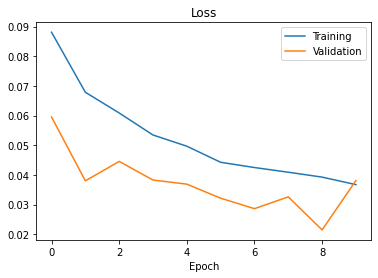

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('Training','Validation'))
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h6')

from google.colab import files
files.download('model.h6')

NameError: ignored